# Set up

### Libraries

In [2]:
import inflection
import math
import datetime

import pandas as pd
import numpy as np
import seaborn as sns


from IPython.display        import Image
from matplotlib             import pyplot as plt
from IPython.display        import HTML

### Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

### Import data

In [5]:
df_sales_raw = pd.read_csv('dataset/train_rossmann.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store_rossmann.csv', low_memory=False)

# merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')

## ETL

#### Data raw status 

In [6]:
# Saving
df1 = df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
df1.dtypes

# Need changes: 

# Date                          object
# DayOfWeek                      int64
# SchoolHoliday                  int64
# CompetitionOpenSinceMonth    float64
# CompetitionOpenSinceYear     float64
# Promo2SinceWeek              float64
# Promo2SinceYear              float64

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [9]:
df1.isna().sum()

# Need change:

# CompetitionDistance            2642
# CompetitionOpenSinceMonth    323348
# CompetitionOpenSinceYear     323348
# Promo2SinceWeek              508031
# Promo2SinceYear              508031
# PromoInterval                508031

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

### Rename Columns

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
cols_new = list (map ( snakecase, cols_old))

# Rename
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### Fillout NA

In [11]:
# Changing date type

df1['date'] = pd.to_datetime( df1['date'])

In [12]:
# competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan (x) else x )

# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval                  508031
month_map = {1: 'Jan', 1: 'Feb', 1: 'Apr', 1: 'May', 1: 'Jun', 1: 'Jul', 1: 'Aug', 1: 'Sept', 1: 'Oct', 1: 'Nov', 1: 'Dec', }

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split('.') else 0 , axis=1  )

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### Change Data Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# Descriptive Statistical

### Data Dimensions

In [14]:
# Data Dimensions

print(f'Number of Rows {df1.shape[0]}')
print(f'Number of Columns {df1.shape[1]}')


Number of Rows 1017209
Number of Columns 20


### Basics Statistics

In [15]:
# Split into categorical and numerical attibutes

num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( include=['object'])


In [16]:
# Cental Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( np.min )).T
d3 = pd.DataFrame(num_attributes.apply( np.max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T


# Concatenate
table_m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
table_m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

table_m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000


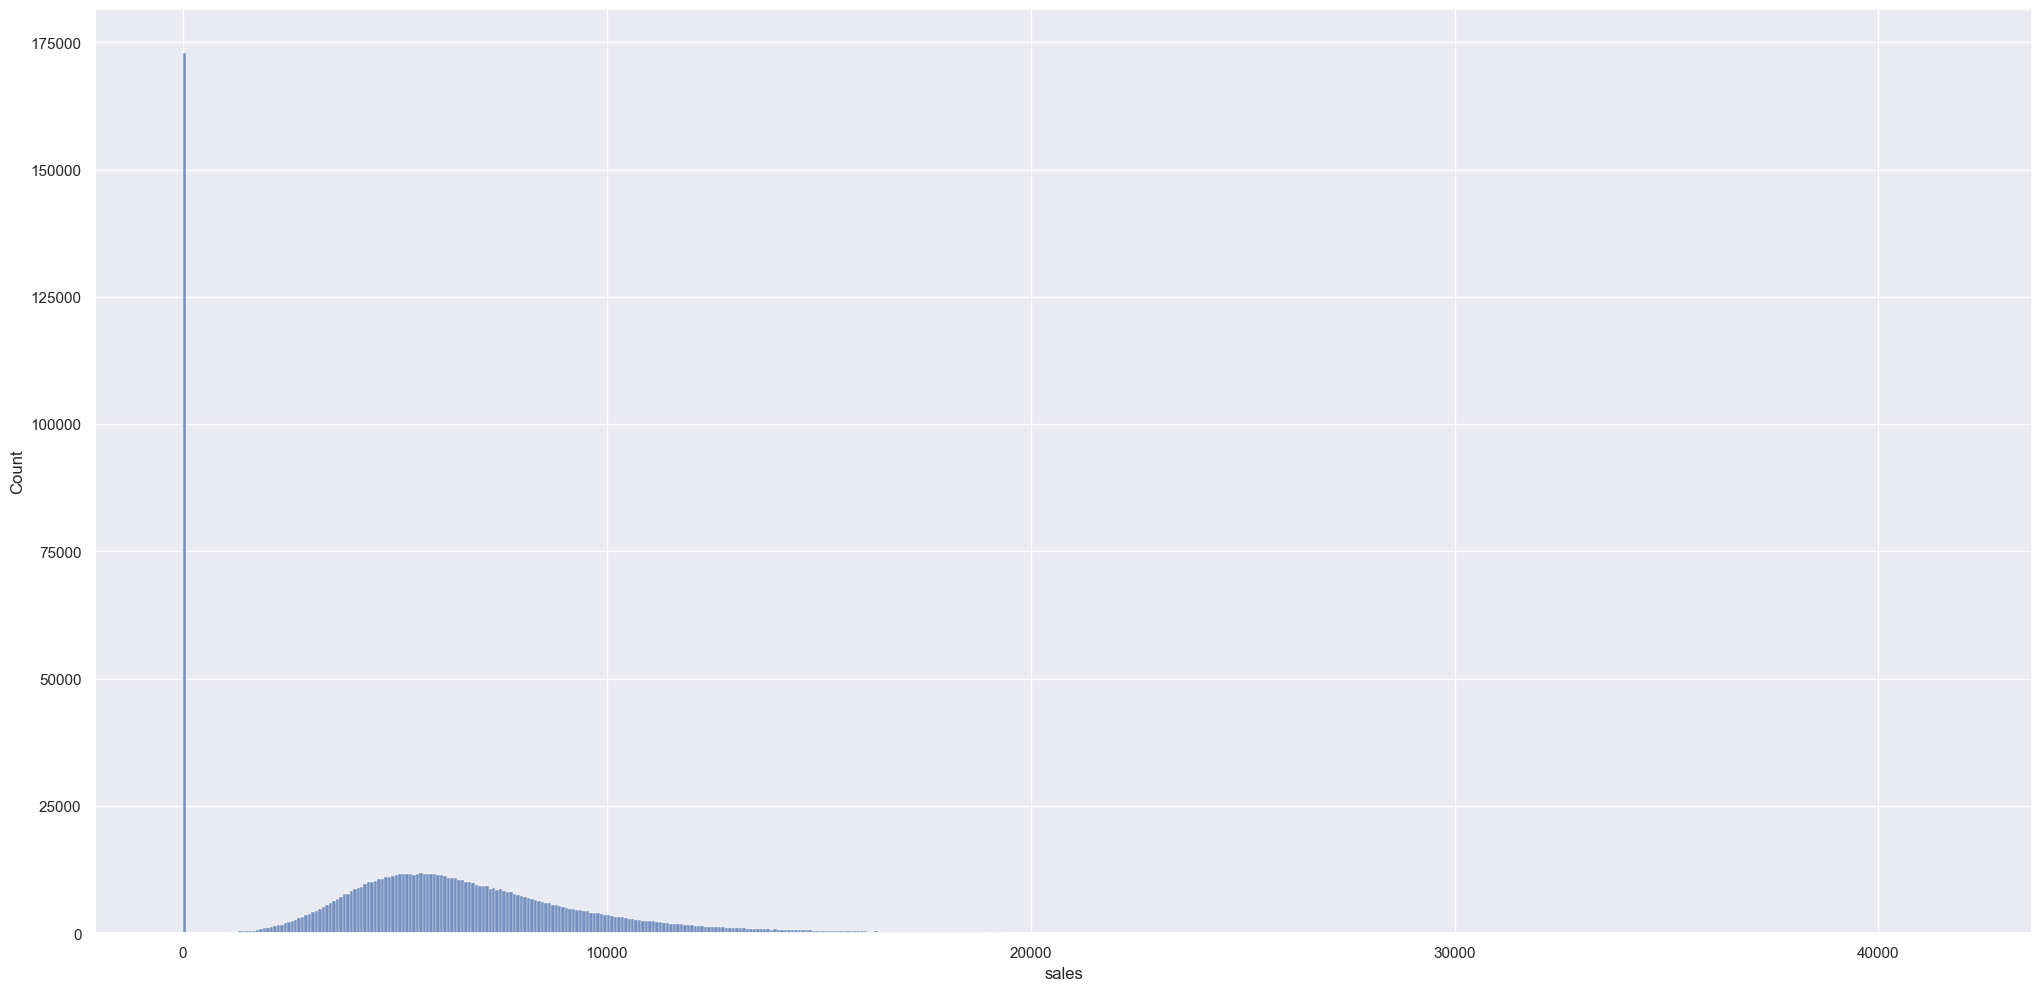

In [17]:
sns.histplot(df1['sales']);

In [18]:
# See the categorical atributes

cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
month_map         2
dtype: int64

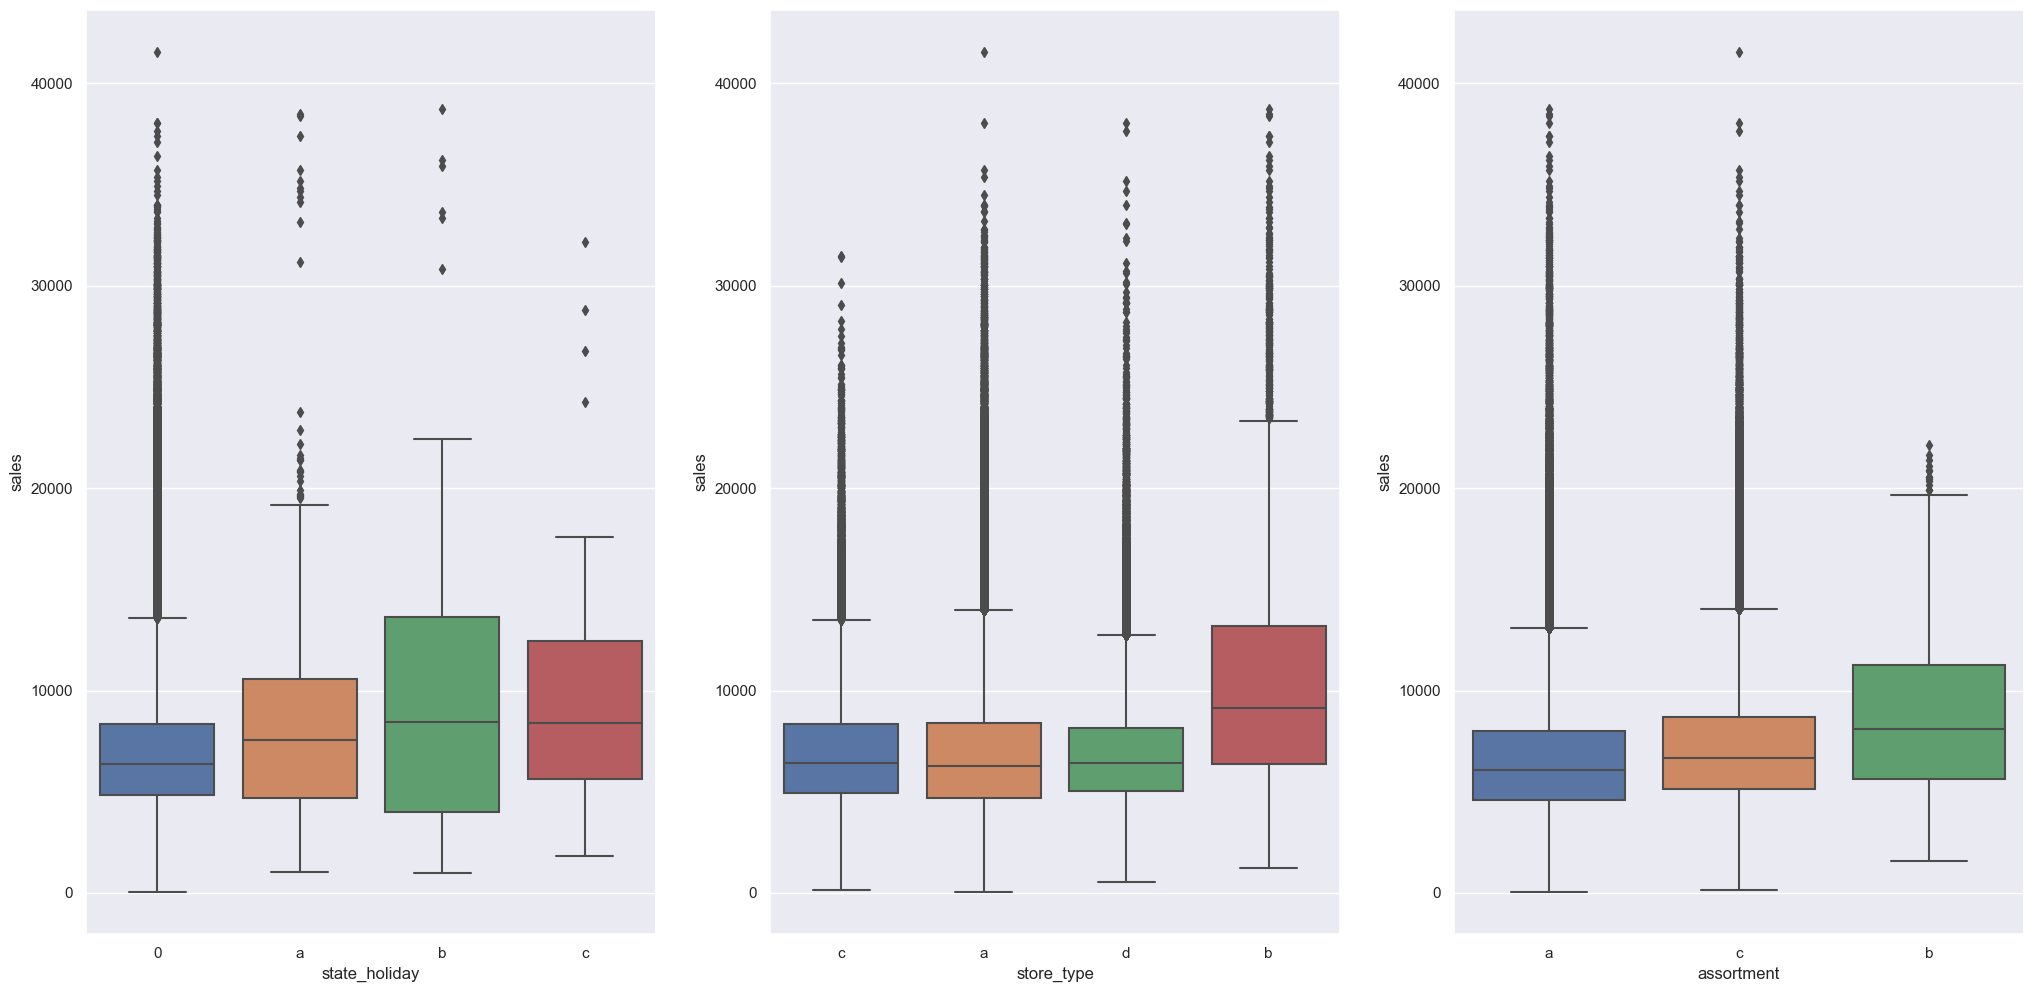

In [19]:
aux1 = df1[( df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# Feature Engineering

### Mental Map

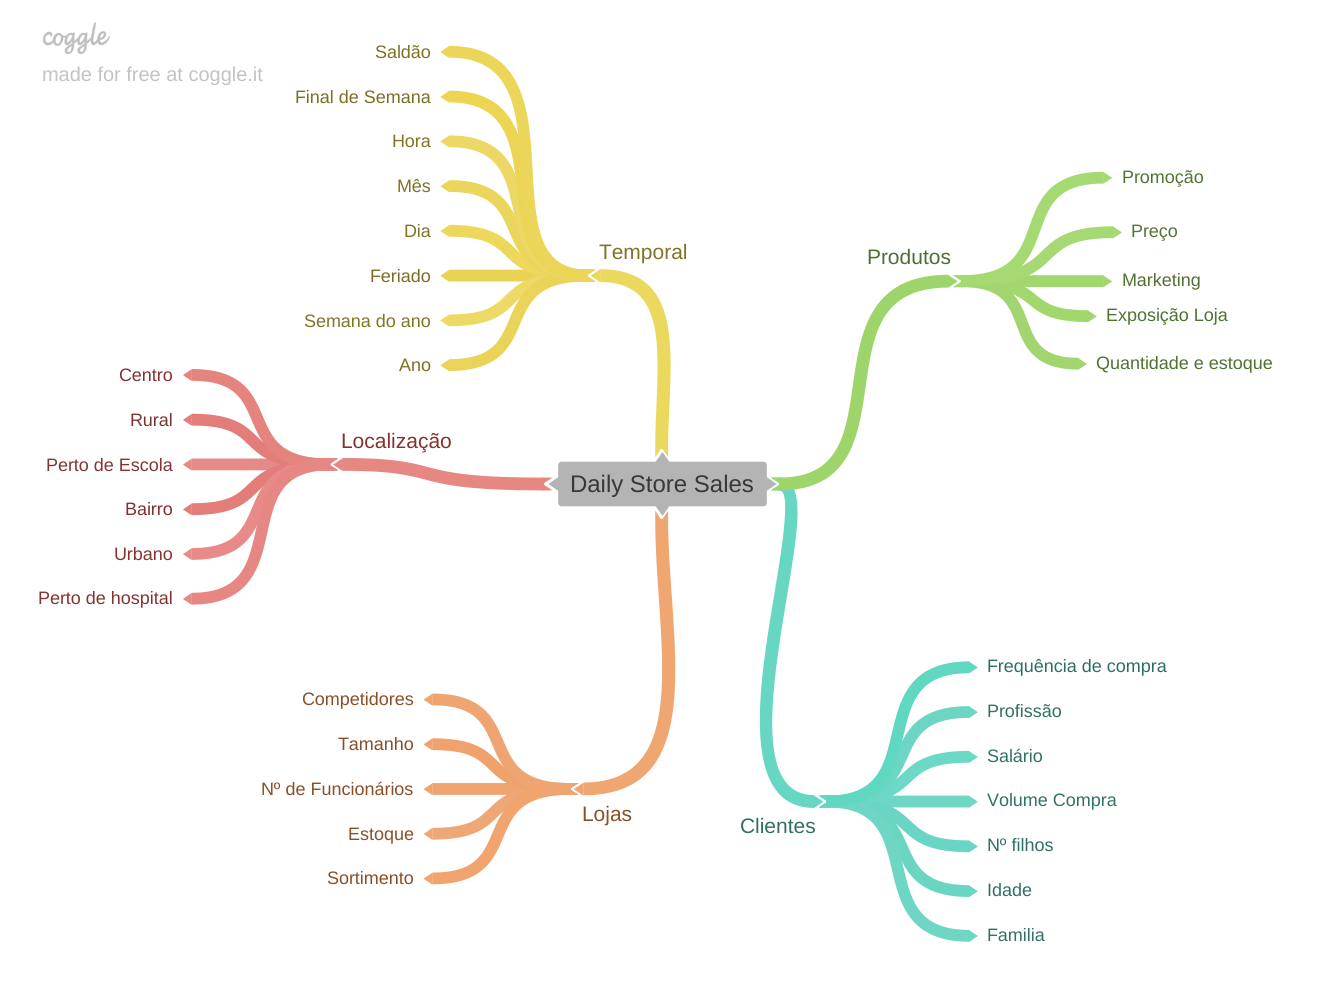

In [20]:
df2= df1.copy()
Image('img/mindmap.png')

### Hyphoteses List



1. Lojas com maior sortimento deveriam vender mais
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores há mais tempo deveriam vender mais
4. Lojas com promoções mais agressivas (maior desconto) deveriam vender mais
5. Lojas com mais dias de promoção deveriam vender mais
6. Lojas com mais promoções consecutivas deveriam vender mais
7. Lojas abertas durante feriado final do ano deveriam vender mais
8. Lojas deveriam vender mais ao longo dos anos
9. Lojas deveriam vender mais no segundo semestre do ano
10. Lojas deveriam vender mais depois do dia 10 de cada mês
11. Lojas deveriam vender menos no fds
12. Lojas deveriam vender menos durante os feriados escolares

### Features

In [21]:
# Split Features

# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year Week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Competition Since 
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] =  ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )


# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7 ) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype( int )

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holidday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [22]:
df3 = df2.copy()

# Filtragem
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

# Seleção
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )



## Exploratory Data Analysis 

In [23]:
# Saving
df4 = df3.copy()

### Univariate Analysis

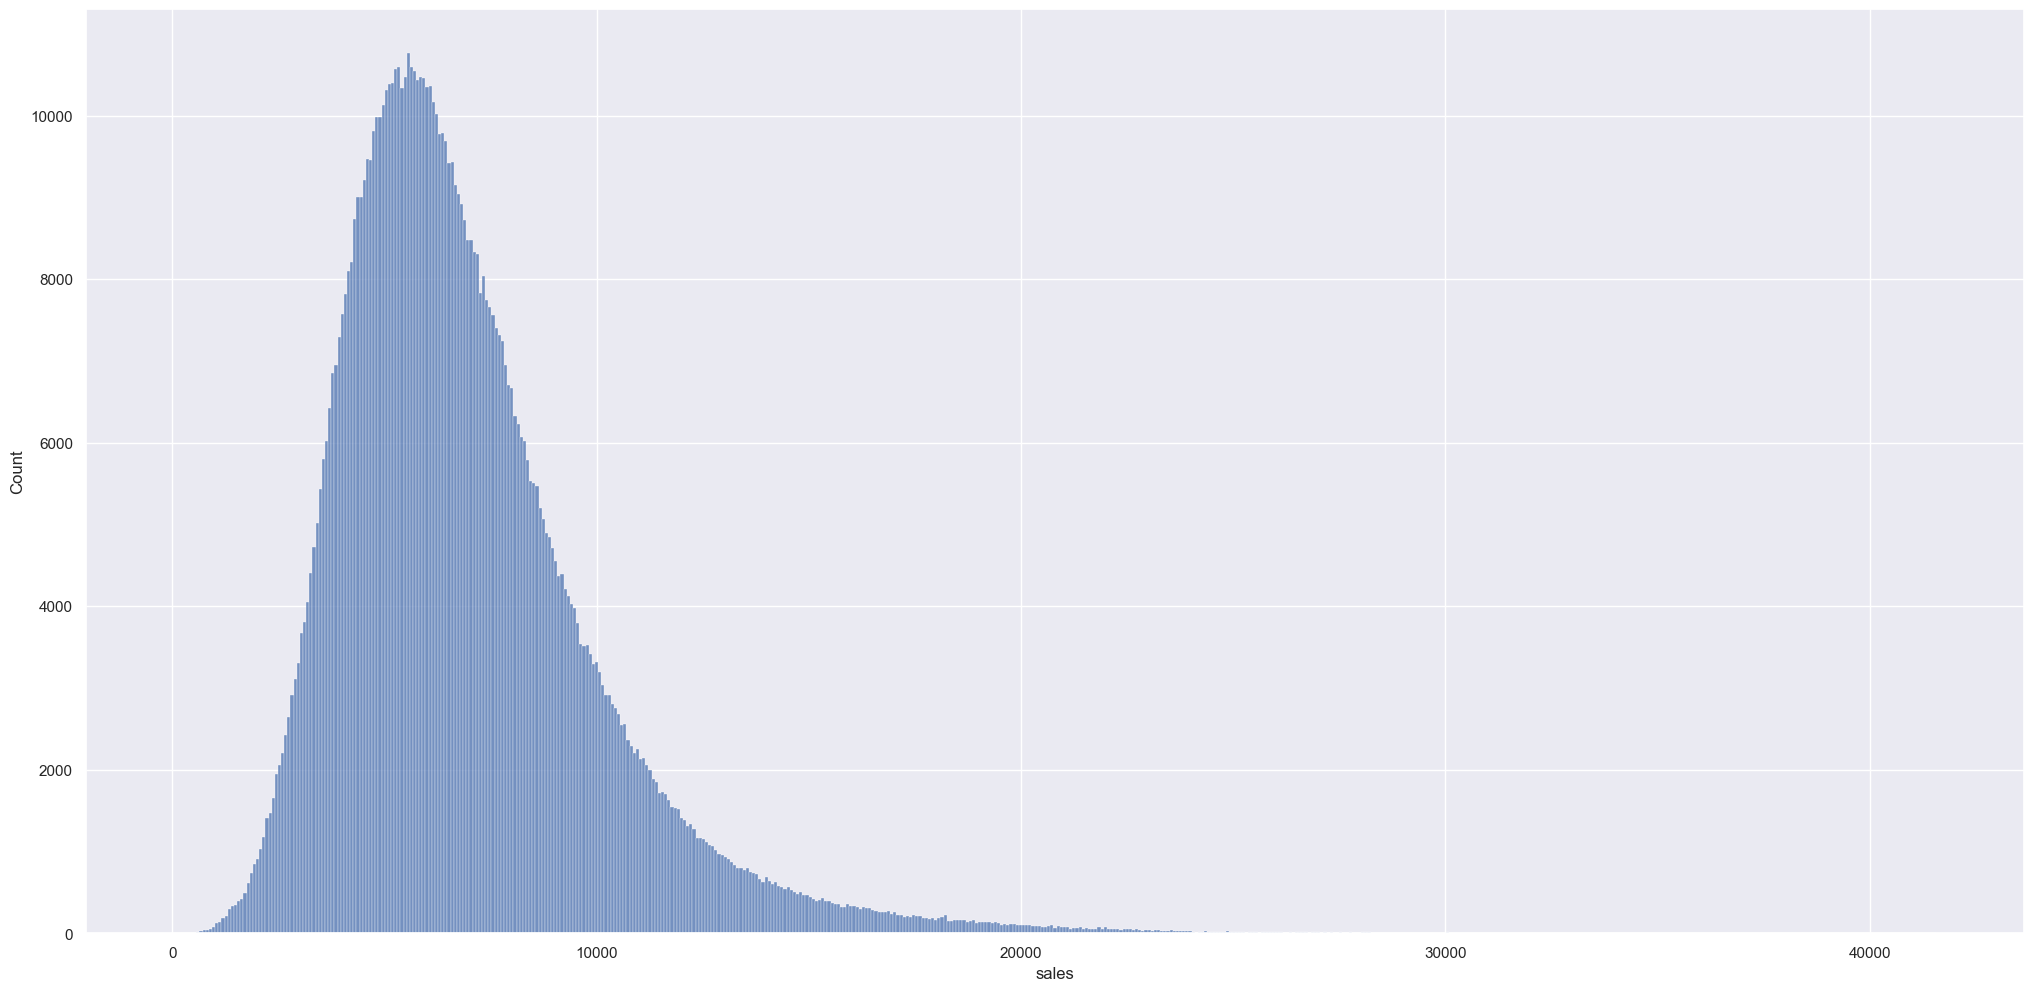

In [24]:
# Response Variabel

sns.histplot( df4['sales'], kde=False);

#### Numerical Variable

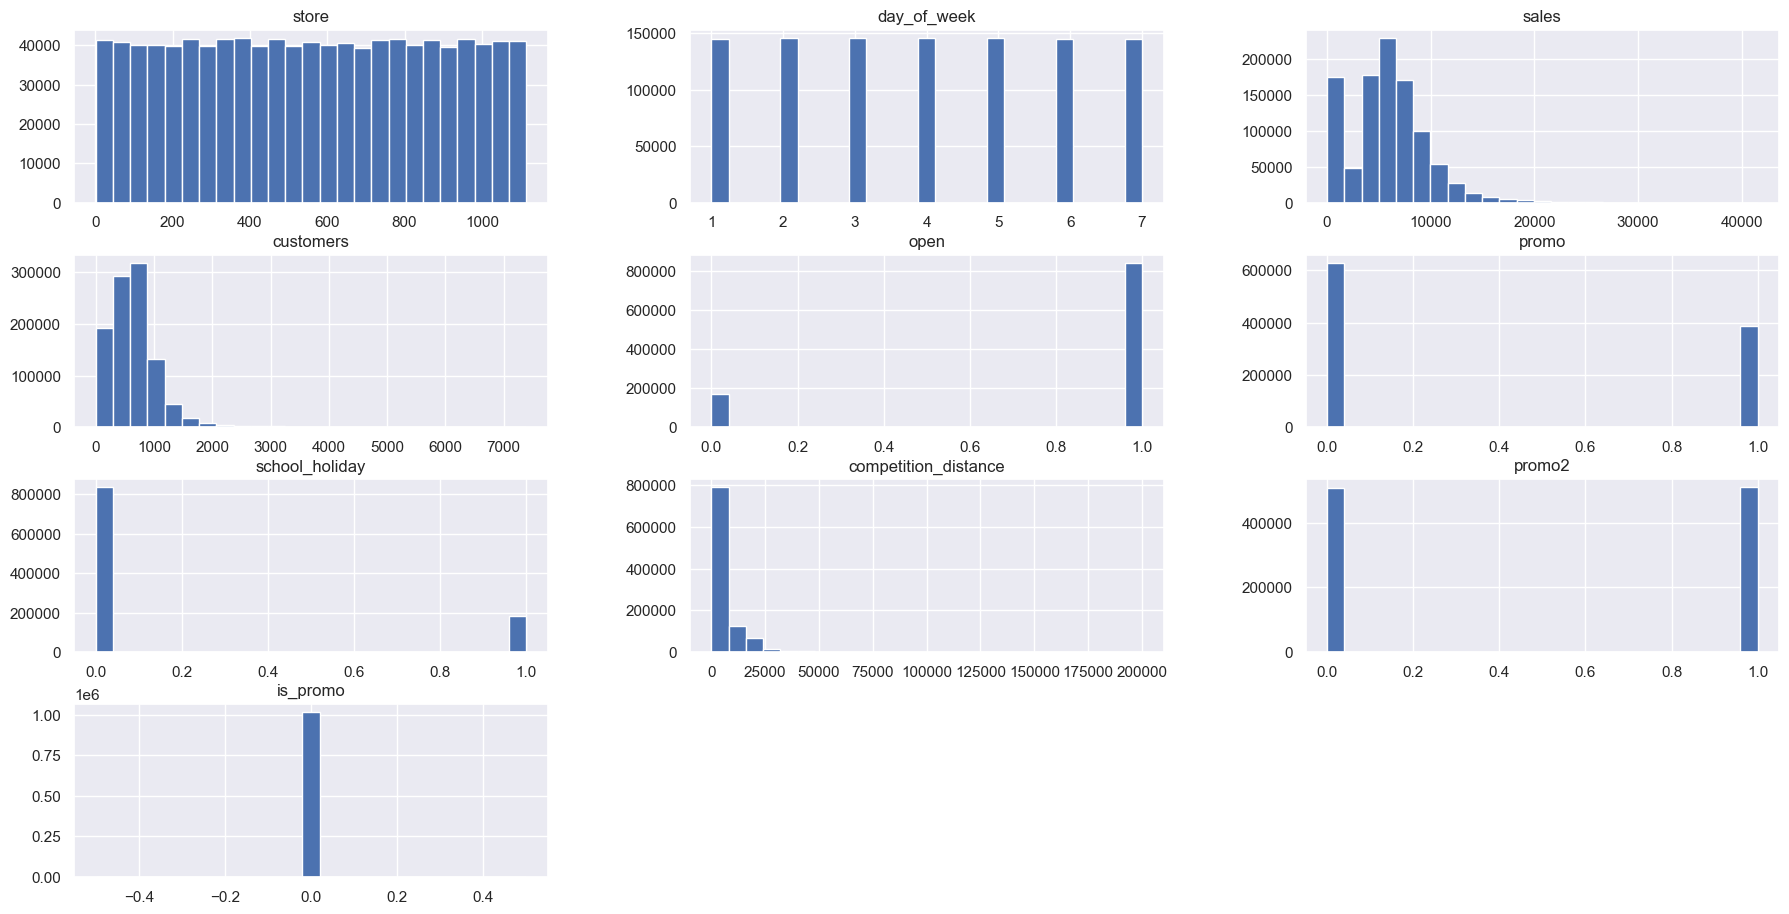

In [25]:


num_attributes.hist( bins=25, figsize=(22, 11) );

#### Categorical Variable

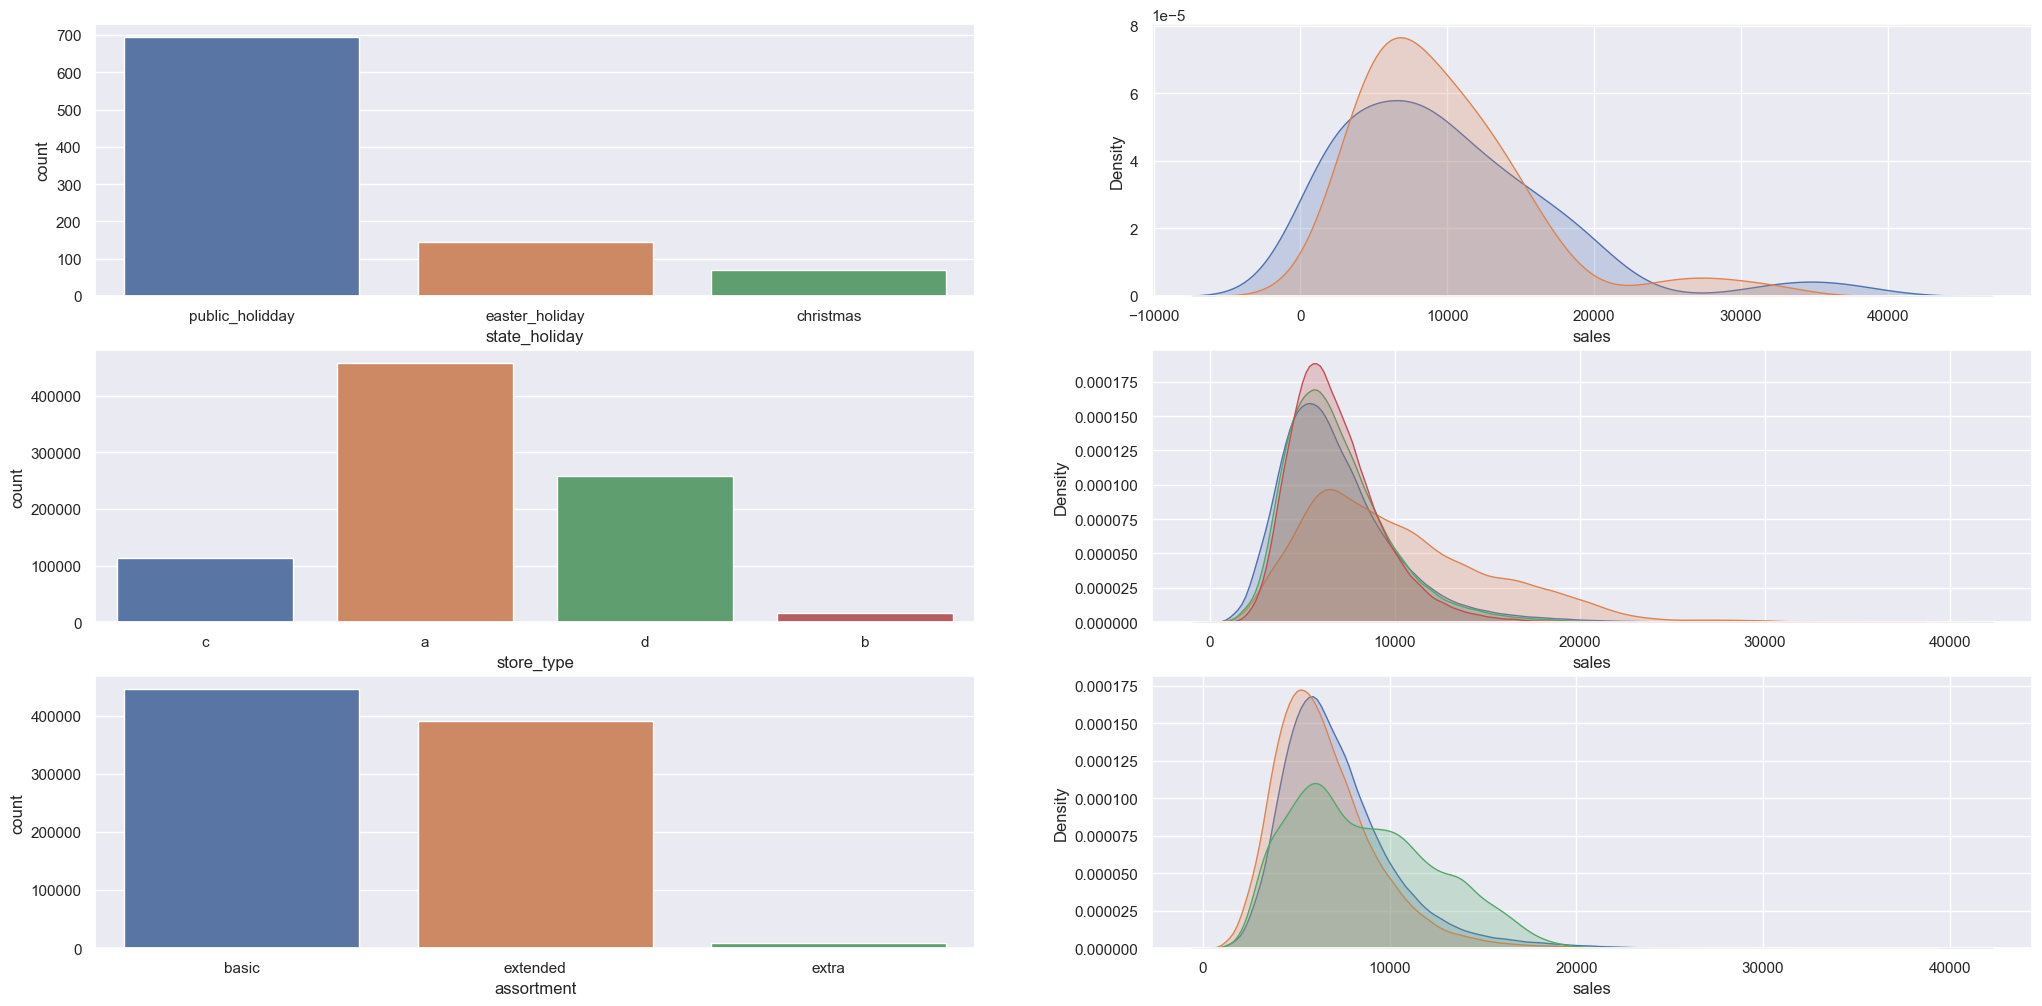

In [30]:
# State Holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'] );

# Waves
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True );
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True );
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True );


#Store type
plt.subplot( 3, 2, 3 )
sns.countplot( x=df4['store_type'] );

#Waves
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True);
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True);
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True);
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True);


# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x=df4['assortment'] );

# Wave
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True);
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True);
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True);

### Bivariate Analysis

### More Relevant

##### **H1.** Lojas com maior sortimentos deveriam vender mais.

 **FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

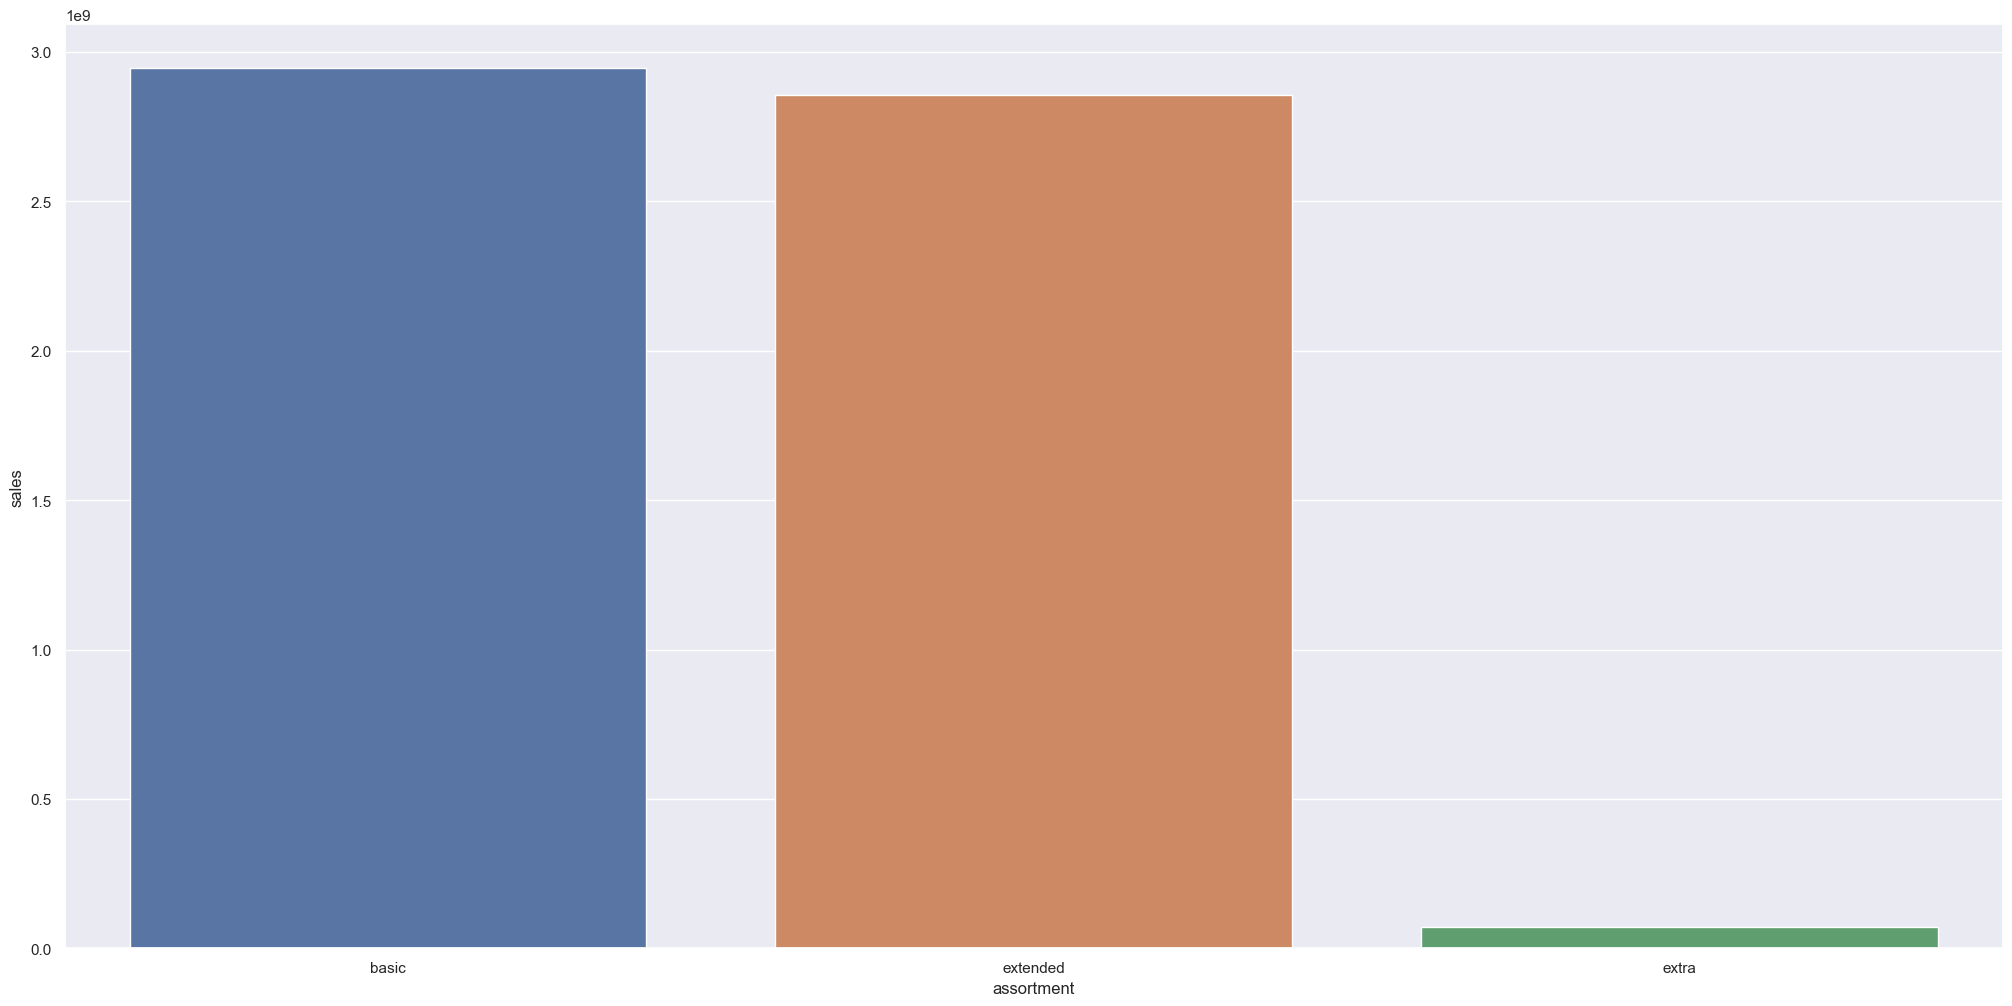

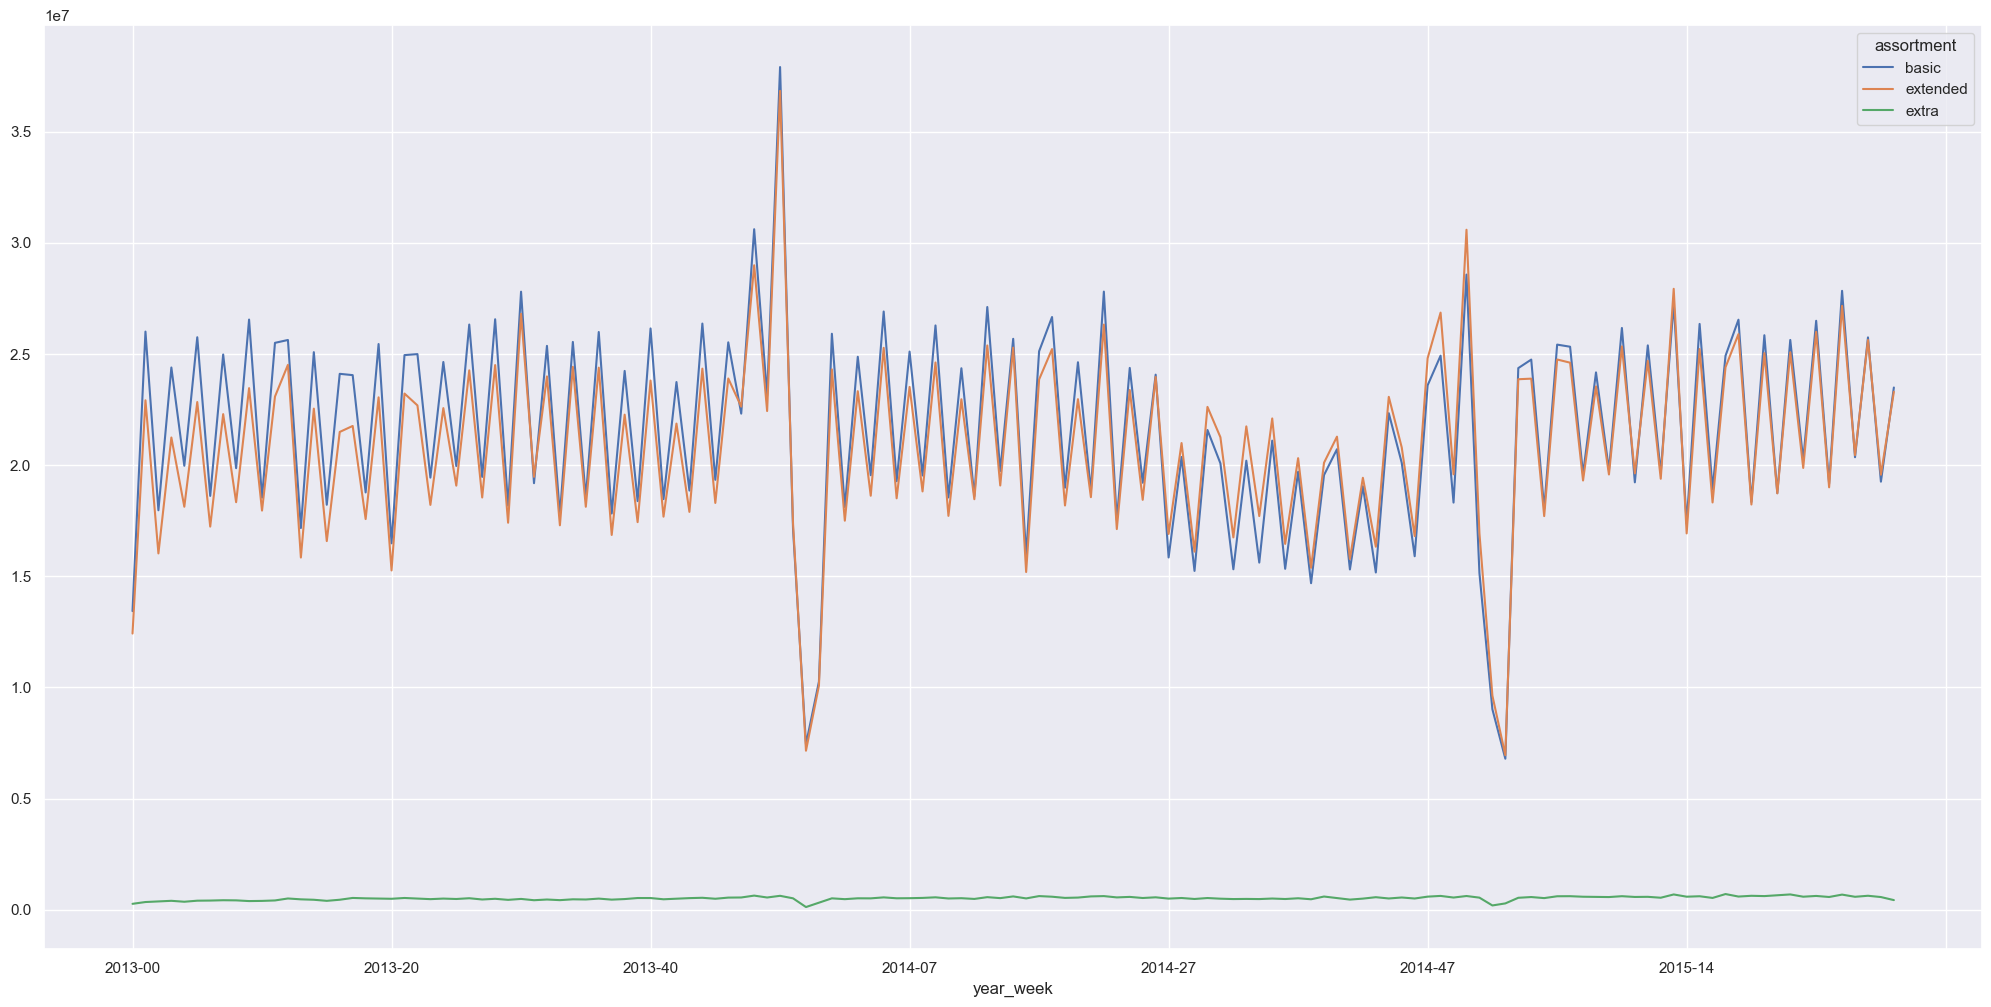

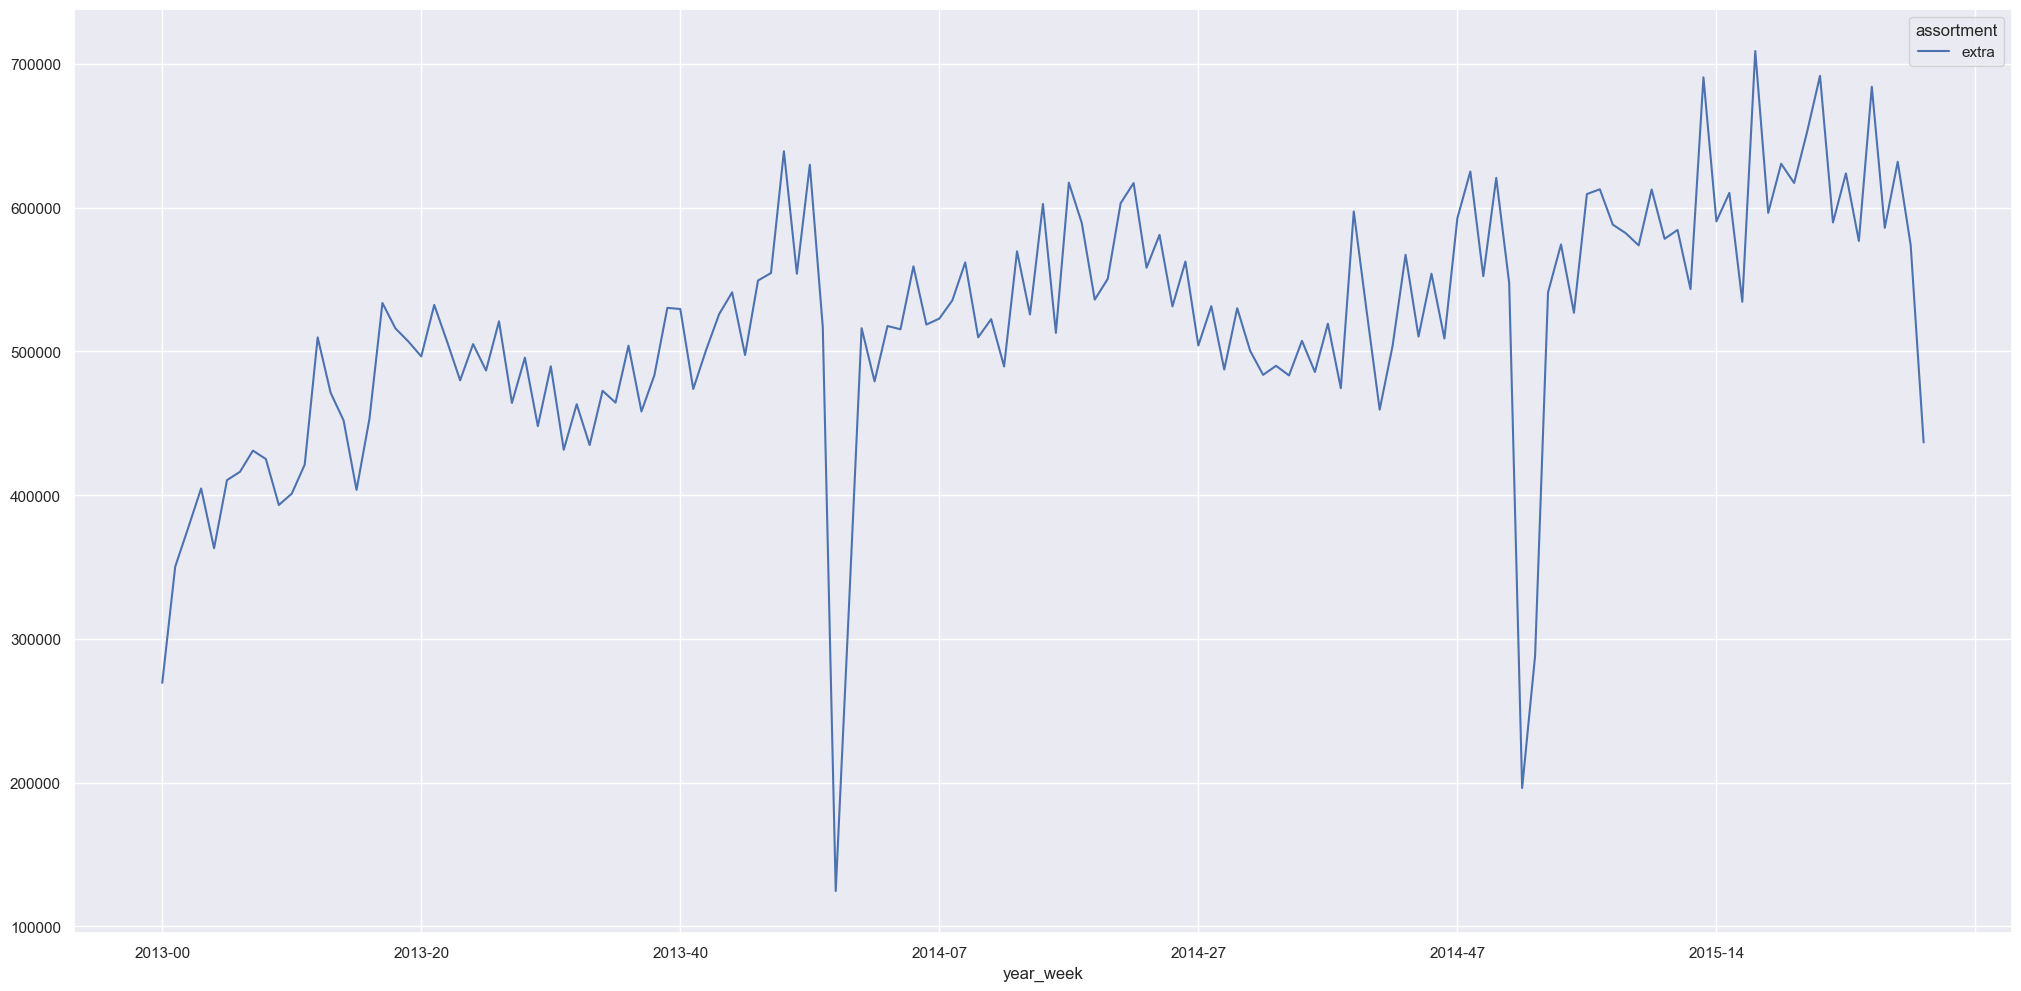

In [58]:
# Total
grf1 = df4[[ 'assortment', 'sales' ]].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=grf1);

# by day
aux2 = df4[[ 'assortment', 'sales', 'year_week' ]].groupby(['year_week', 'assortment']).sum().reset_index()
grf2 = aux2.pivot( index='year_week', columns='assortment', values='sales').plot(); 

# assortment extra
aux3= aux2[aux2['assortment'] == 'extra' ]
grf3 = aux3.pivot( index='year_week', columns='assortment', values='sales').plot(); 



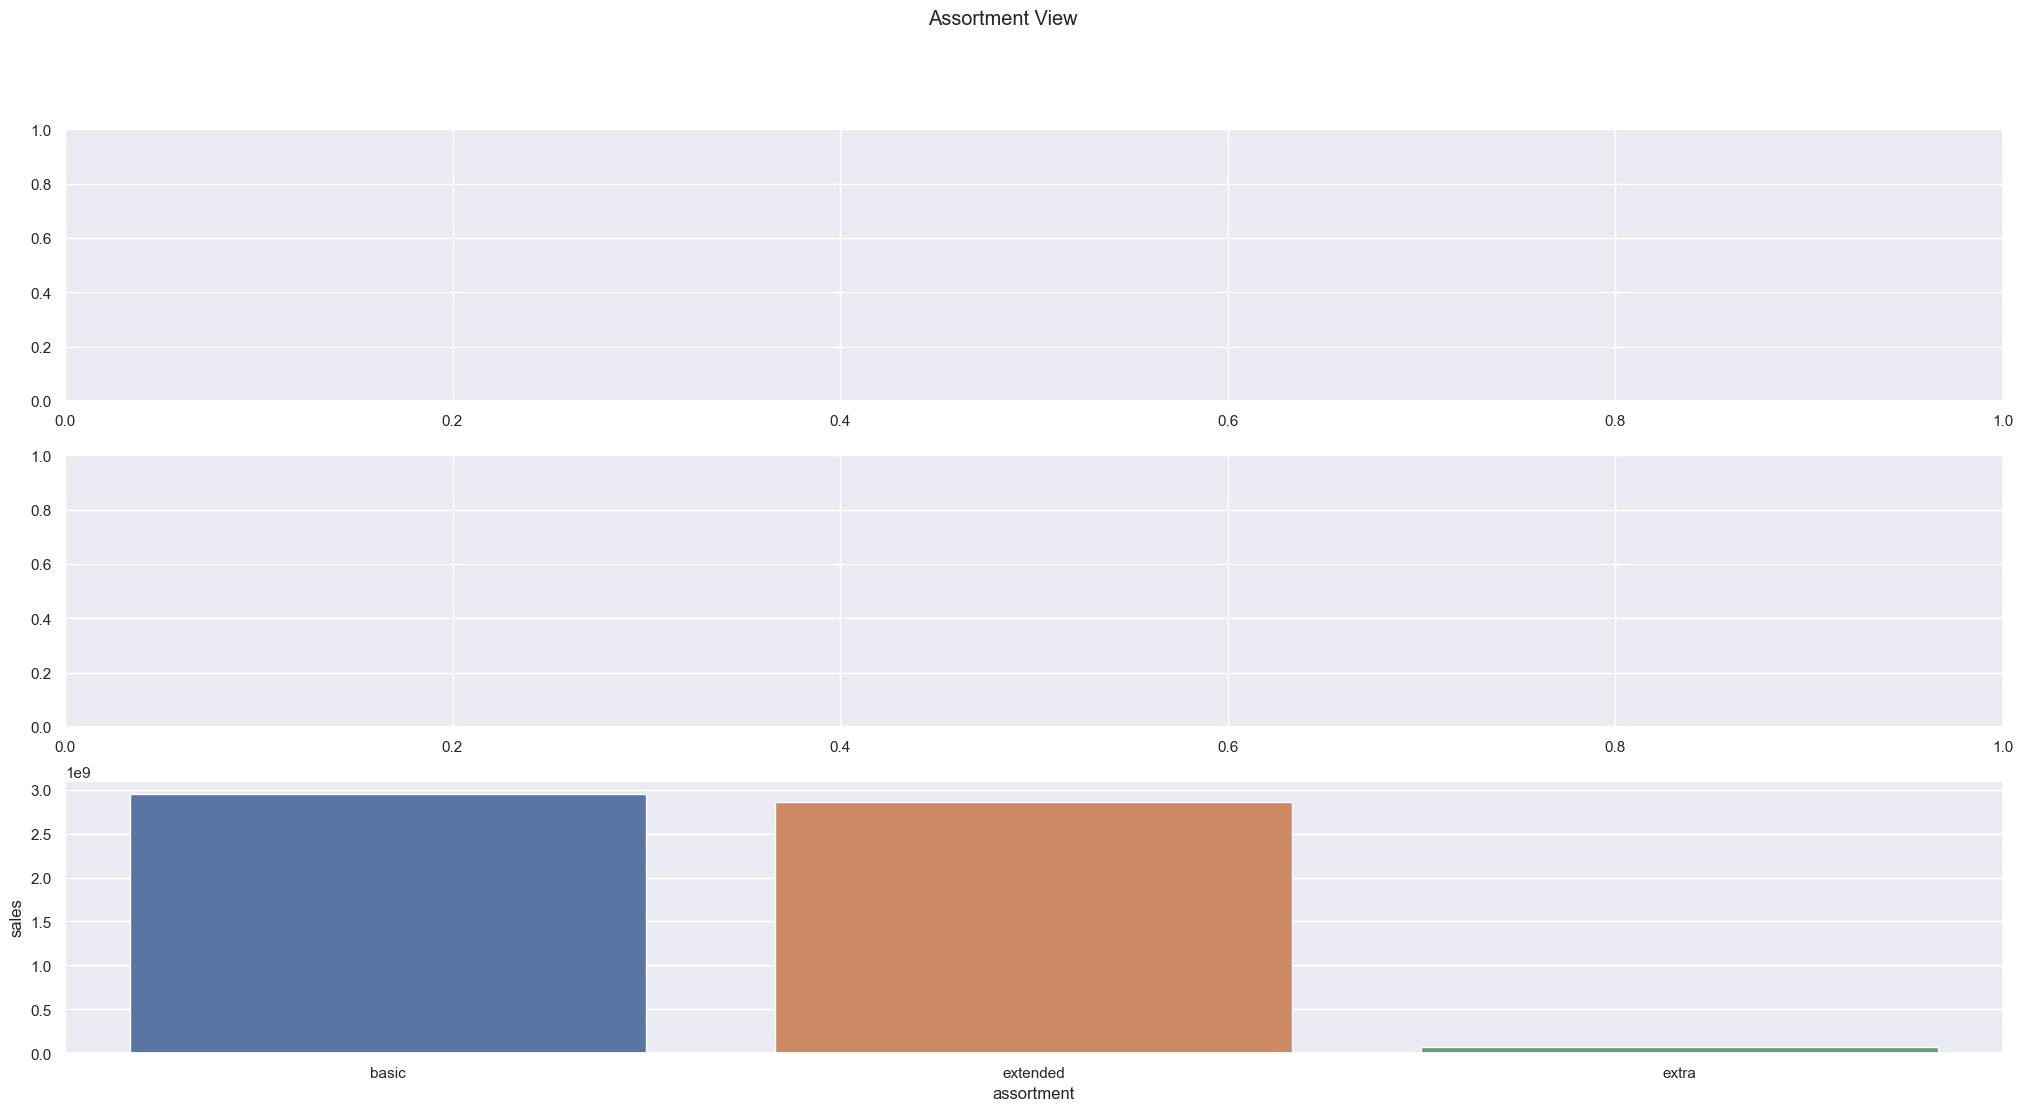

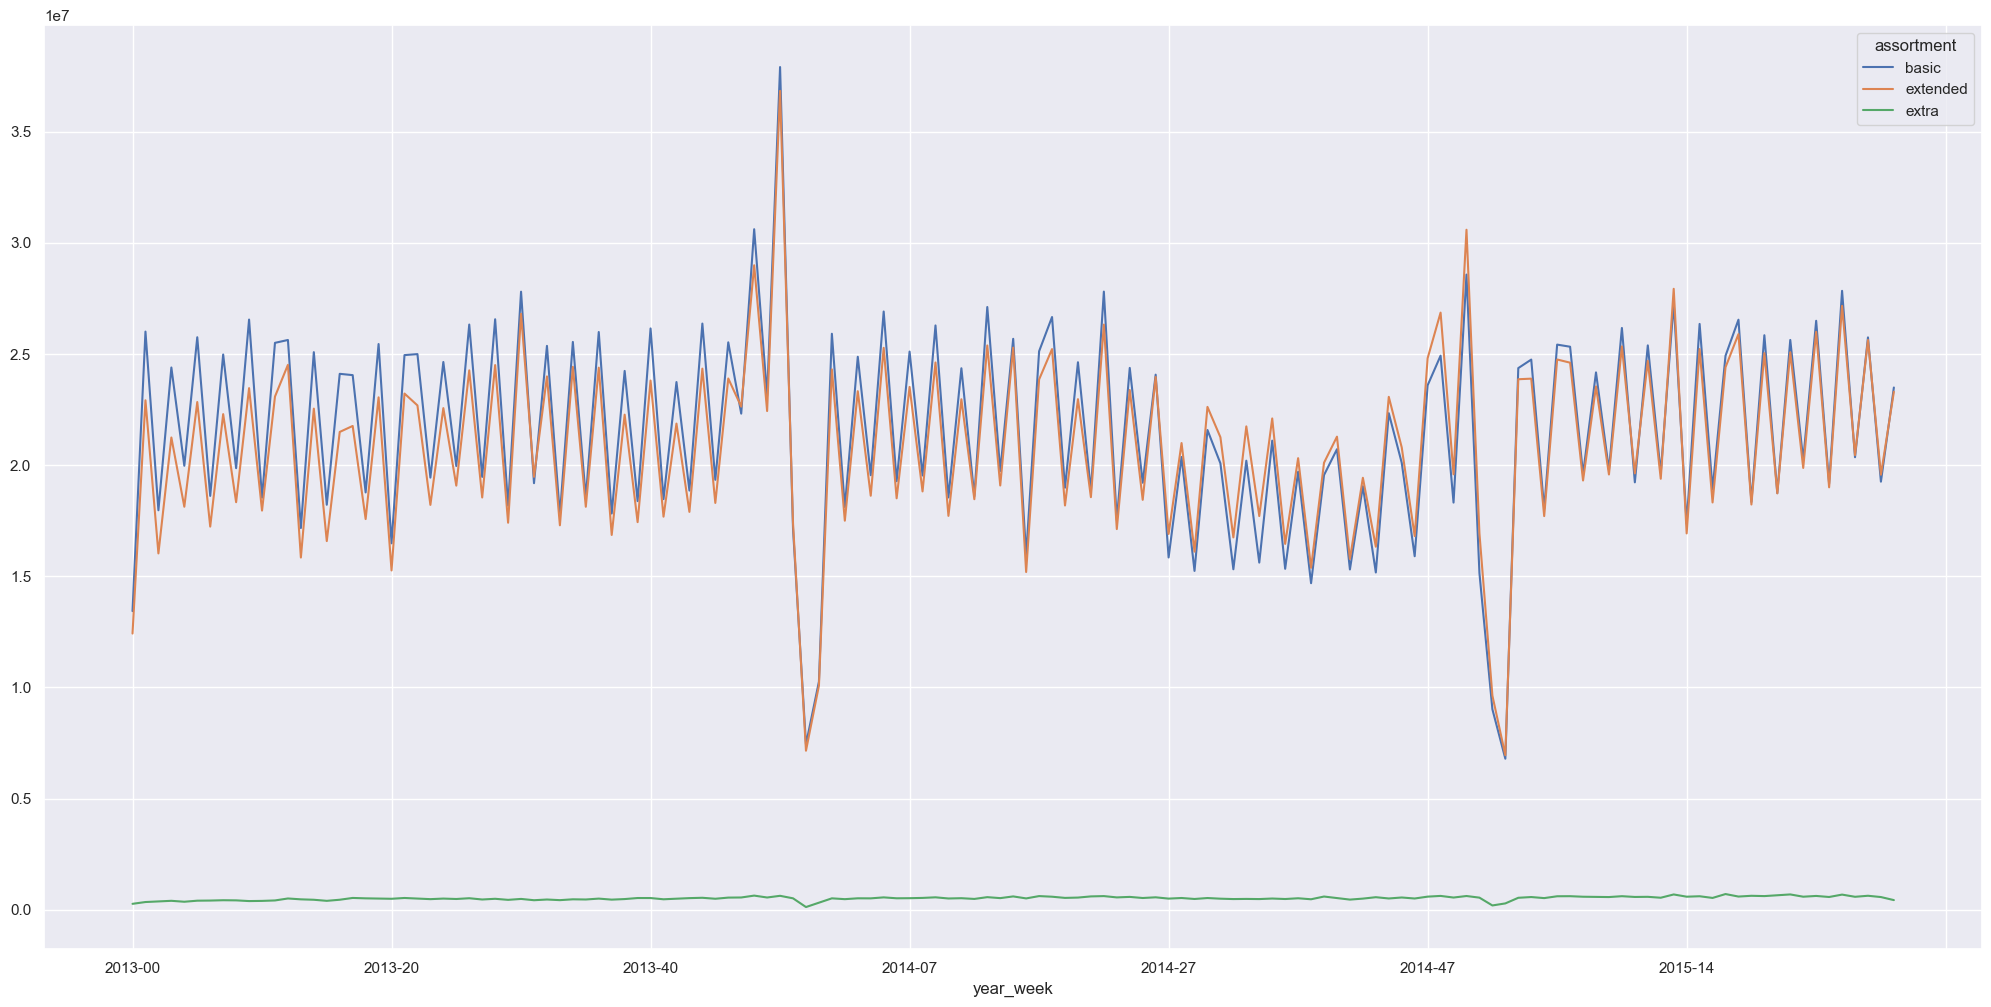

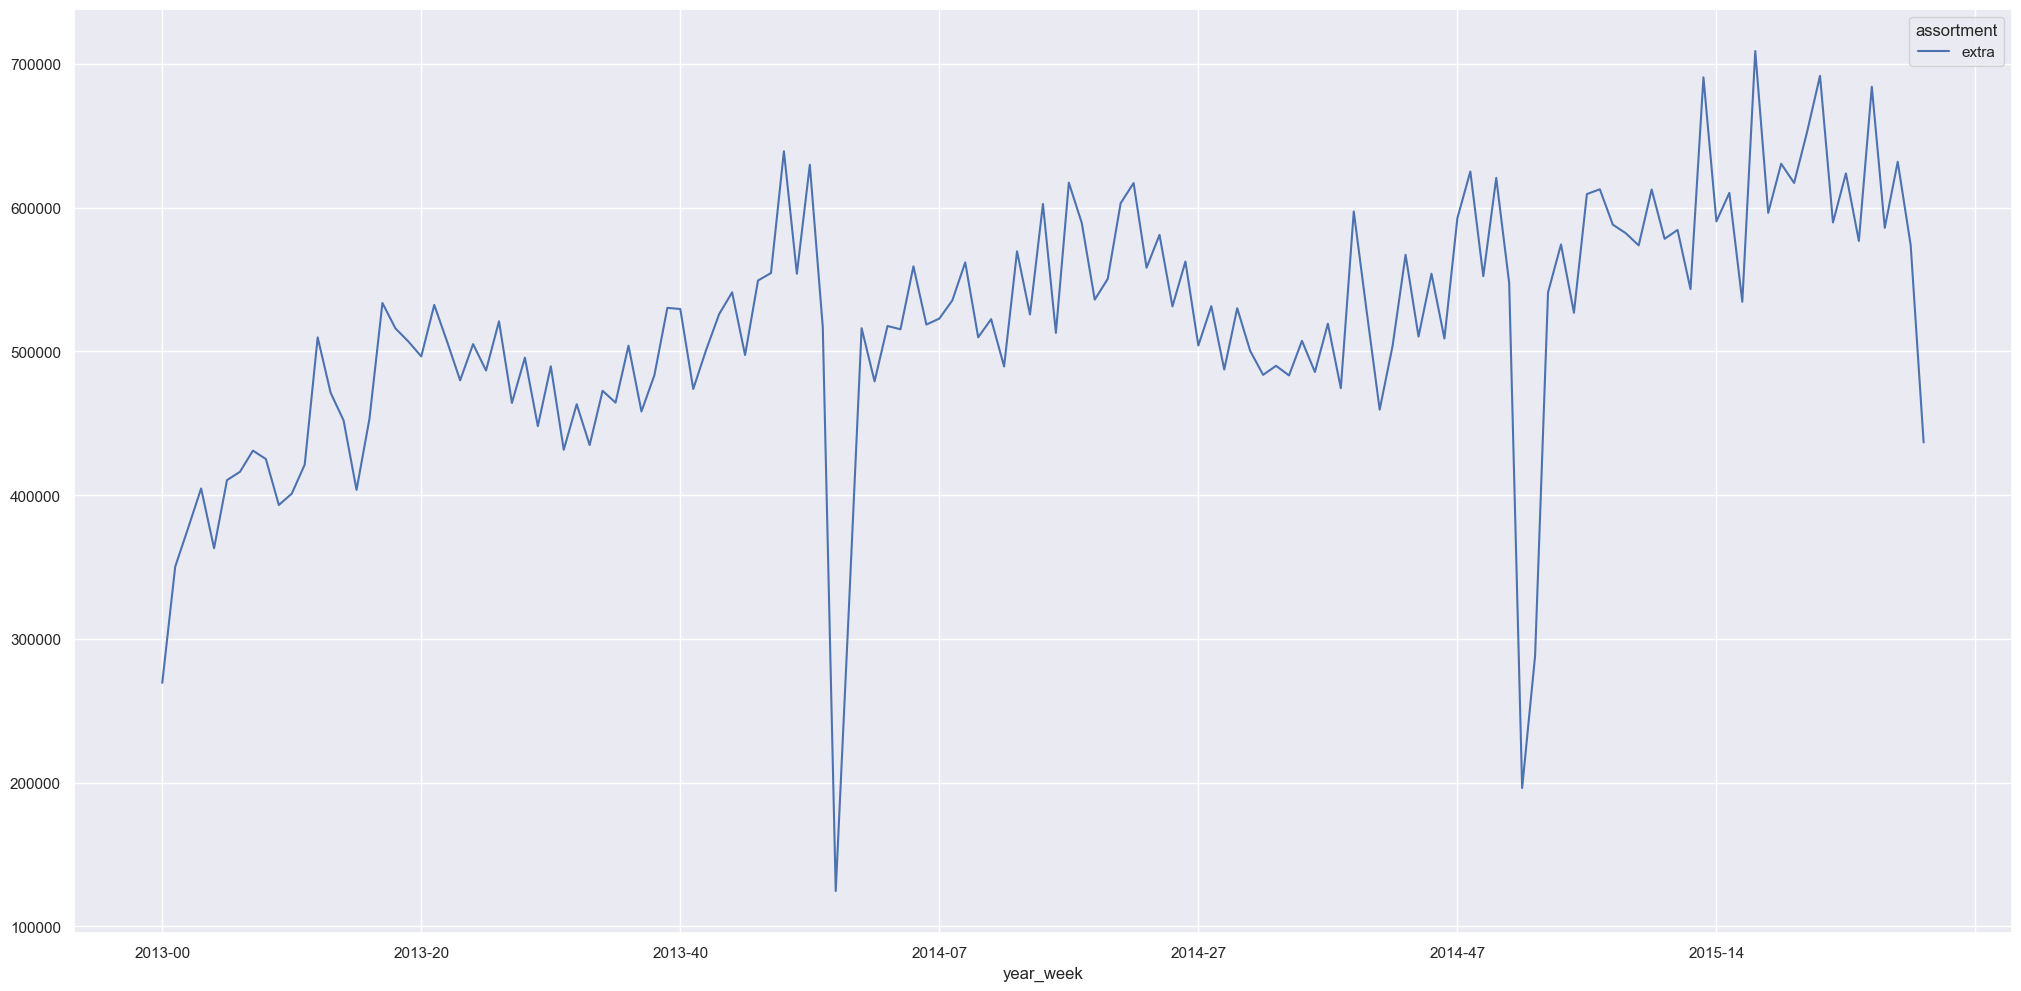

In [53]:
# # Total
# fig, (grf1, grf2, grf3 ) = plt.subplots(3, 1)
# fig.suptitle('Assortment View')

# grf1 = df4[[ 'assortment', 'sales' ]].groupby('assortment').sum().reset_index()
# sns.barplot( x='assortment', y='sales', data=grf1);

# # by day
# grf2 = df4[[ 'assortment', 'sales', 'year_week' ]].groupby(['year_week', 'assortment']).sum().reset_index()
# grf2.pivot( index='year_week', columns='assortment', values='sales').plot(); 


# # assortment extra
# grf3 = aux2[aux2['assortment'] == 'extra' ]
# grf3.pivot( index='year_week', columns='assortment', values='sales').plot(); 

# plt.show()


##### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

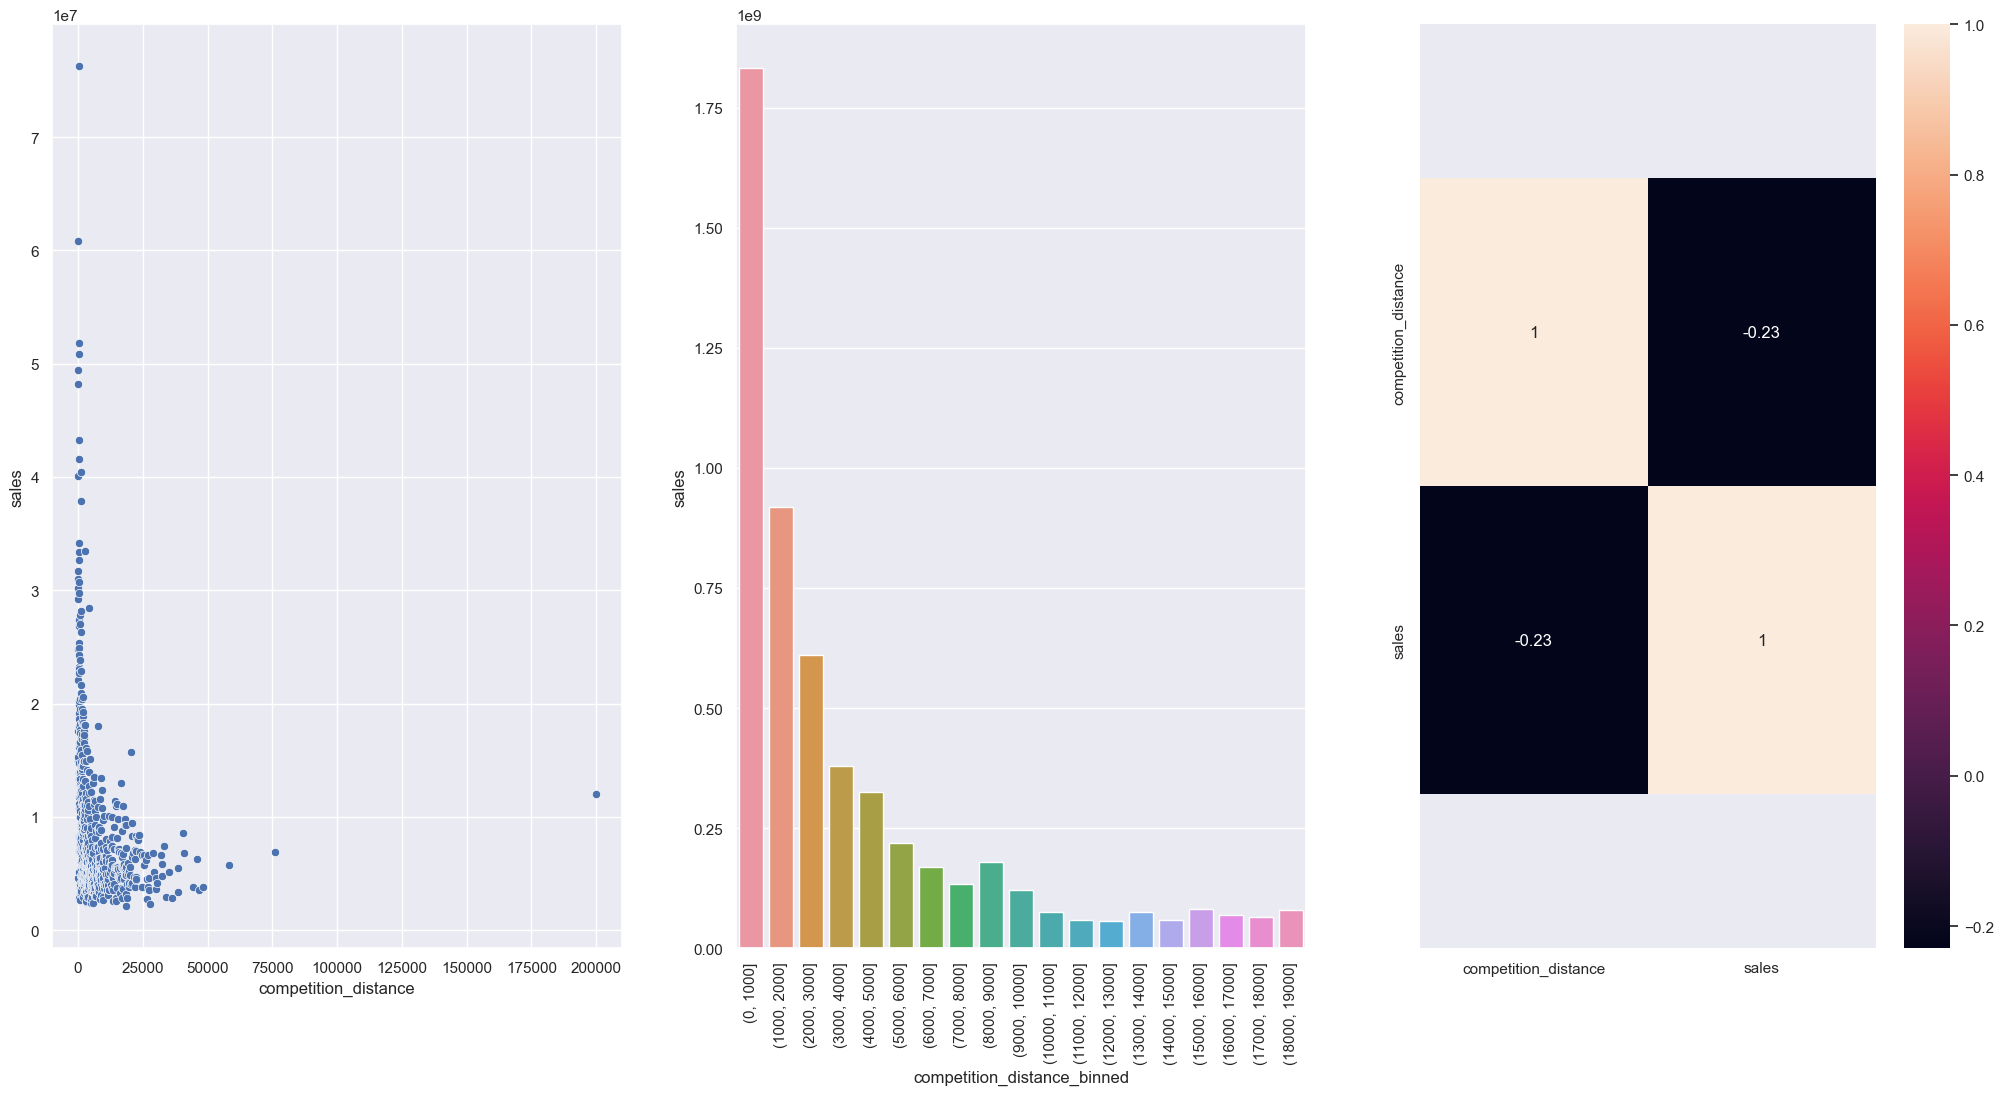

In [74]:
# h2 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# plt.subplot( 1, 3, 1)
# sns.scatterplot( x='competition_distance', y='sales', data=h2 );

# plt.subplot( 1, 3, 2)
# bins = list( np.arange(0, 20000, 1000) )
# h2['competition_distance_binned'] = pd.cut( h2['competition_distance'], bins=bins )
# aux2 = h2[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
# sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
# plt.xticks( rotation=90 );

# plt.subplot( 1, 3, 3 )
# x = sns.heatmap( h2.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

##### **H6.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

##### **H9.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

### Less Relevant

##### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

##### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

##### **H5.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

##### **H7.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

##### **H8.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

##### **H10.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

##### **H11.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

### Análise Multivariada